In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive")

Mounted at /content/drive


# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [ ]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [ ]:
!pip install plot_keras_history

In [ ]:
!cd "/content/drive/MyDrive/Colab Notebooks/NN&NLP/DAT_lab11/"
!unzip swda.zip

unzip:  cannot find or open swda.zip, swda.zip.zip or swda.zip.ZIP.


In [ ]:
f = glob.glob("/content/drive/MyDrive/Colab Notebooks/NN&NLP/DAT_lab11/swda/sw*/sw*.csv")
frames = []
print(len(f))
for i in range(0, len(f)):
    if i+1%5 ==0:
        print(i)
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


1155


In [ ]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [ ]:
reduced_df = result[['act_tag','text']]


Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [ ]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [ ]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

To get unique tags:

In [ ]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [ ]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [ ]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [ ]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [ ]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [ ]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


The dataset is divided into two sections: test and training.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)


Pad each utterance to make them all the same length.




In [ ]:
MAX_LENGTH = 150

In [ ]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [ ]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [ ]:
train_input[11050]


array([  50, 3400,  114, 1351,    7,    5,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [ ]:
sentence_embeddings[11050]

[50, 3400, 114, 1351, 7, 5]

# Model 1 - 

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

The model architecture is as follows: Embedding Layer (to generate word 
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.


In [ ]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, Activation, Embedding
from tensorflow.keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

# Embedding layer
# Bidirectional 1
# Bidirectional 2
# Dense layer
# Activation
model = Sequential(
    [
     Embedding(mask_zero = False, input_dim = VOCAB_SIZE + 1, output_dim = EMBED_SIZE, input_length = MAX_LENGTH),
     Bidirectional(LSTM(43, return_sequences = True)),
     Bidirectional(LSTM(43, return_sequences = False)),
     Dense(HIDDEN_SIZE),
     Activation('softmax')
    ]
)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          4373300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 43)                3741      
                                                                 
 activation_1 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,297
Trainable params: 4,471,297
No

<font color = "#909191"><b> Here we are creating a sequential model with the embedding layer as the first layer. That layer takes the vocab size as input plus an additional 1 because 0 index has a 0 vector and we lose a word in the matrix. the output dimension is the embedding size while the input_length is the max padding length. We follow that by two Bidirectional LSTM layers with 43 size. One has return sequences as True while the other is False. We follow that with a Dense Layer with hidden_size and the output layer is an acitvation layer with softmax activation function.</b></font>

In [ ]:
# Train the model - use validation 
history = model.fit(train_input,
                    train_labels,
                    epochs=10,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    verbose=1)

Epoch 1/10
547/547 [==============================] - 28s 40ms/step - loss: 1.5651 - accuracy: 0.5595 - val_loss: 1.2332 - val_accuracy: 0.6459
Epoch 2/10
547/547 [==============================] - 21s 38ms/step - loss: 1.0550 - accuracy: 0.6912 - val_loss: 1.0506 - val_accuracy: 0.6868
Epoch 3/10
547/547 [==============================] - 21s 38ms/step - loss: 0.8988 - accuracy: 0.7332 - val_loss: 1.0036 - val_accuracy: 0.6979
Epoch 4/10
547/547 [==============================] - 21s 38ms/step - loss: 0.8008 - accuracy: 0.7599 - val_loss: 0.9963 - val_accuracy: 0.7009
Epoch 5/10
547/547 [==============================] - 21s 38ms/step - loss: 0.7361 - accuracy: 0.7760 - val_loss: 0.9980 - val_accuracy: 0.6982
Epoch 6/10
547/547 [==============================] - 21s 38ms/step - loss: 0.6858 - accuracy: 0.7901 - val_loss: 1.0054 - val_accuracy: 0.6957
Epoch 7/10
547/547 [==============================] - 21s 38ms/step - loss: 0.6437 - accuracy: 0.8018 - val_loss: 1.0540 - val_accuracy:

In [ ]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 7s 12ms/step - loss: 1.1658 - accuracy: 0.6812


Overall Accuracy: 68.12278628349304


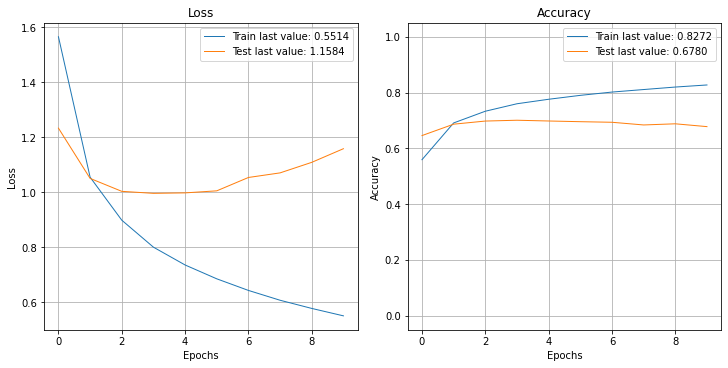

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

print("Overall Accuracy:", score[1]*100)
plot_history(history.history,path = "std.png")
plt.show()

## Evaluation




You should look at the accuracy of some minority classes in addition to overall accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice. 

## Minority Classes

In [ ]:
# Generate predictions for the test data
# Decoding dictionary
decoding_dic= {}

for i in one_hot_encoding_dic.columns:
    decoding_dic[np.argmax(one_hot_encoding_dic[i])] = i

Classes_names = []
for i in range(len(decoding_dic.items())):
    Classes_names.append(decoding_dic[i])
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

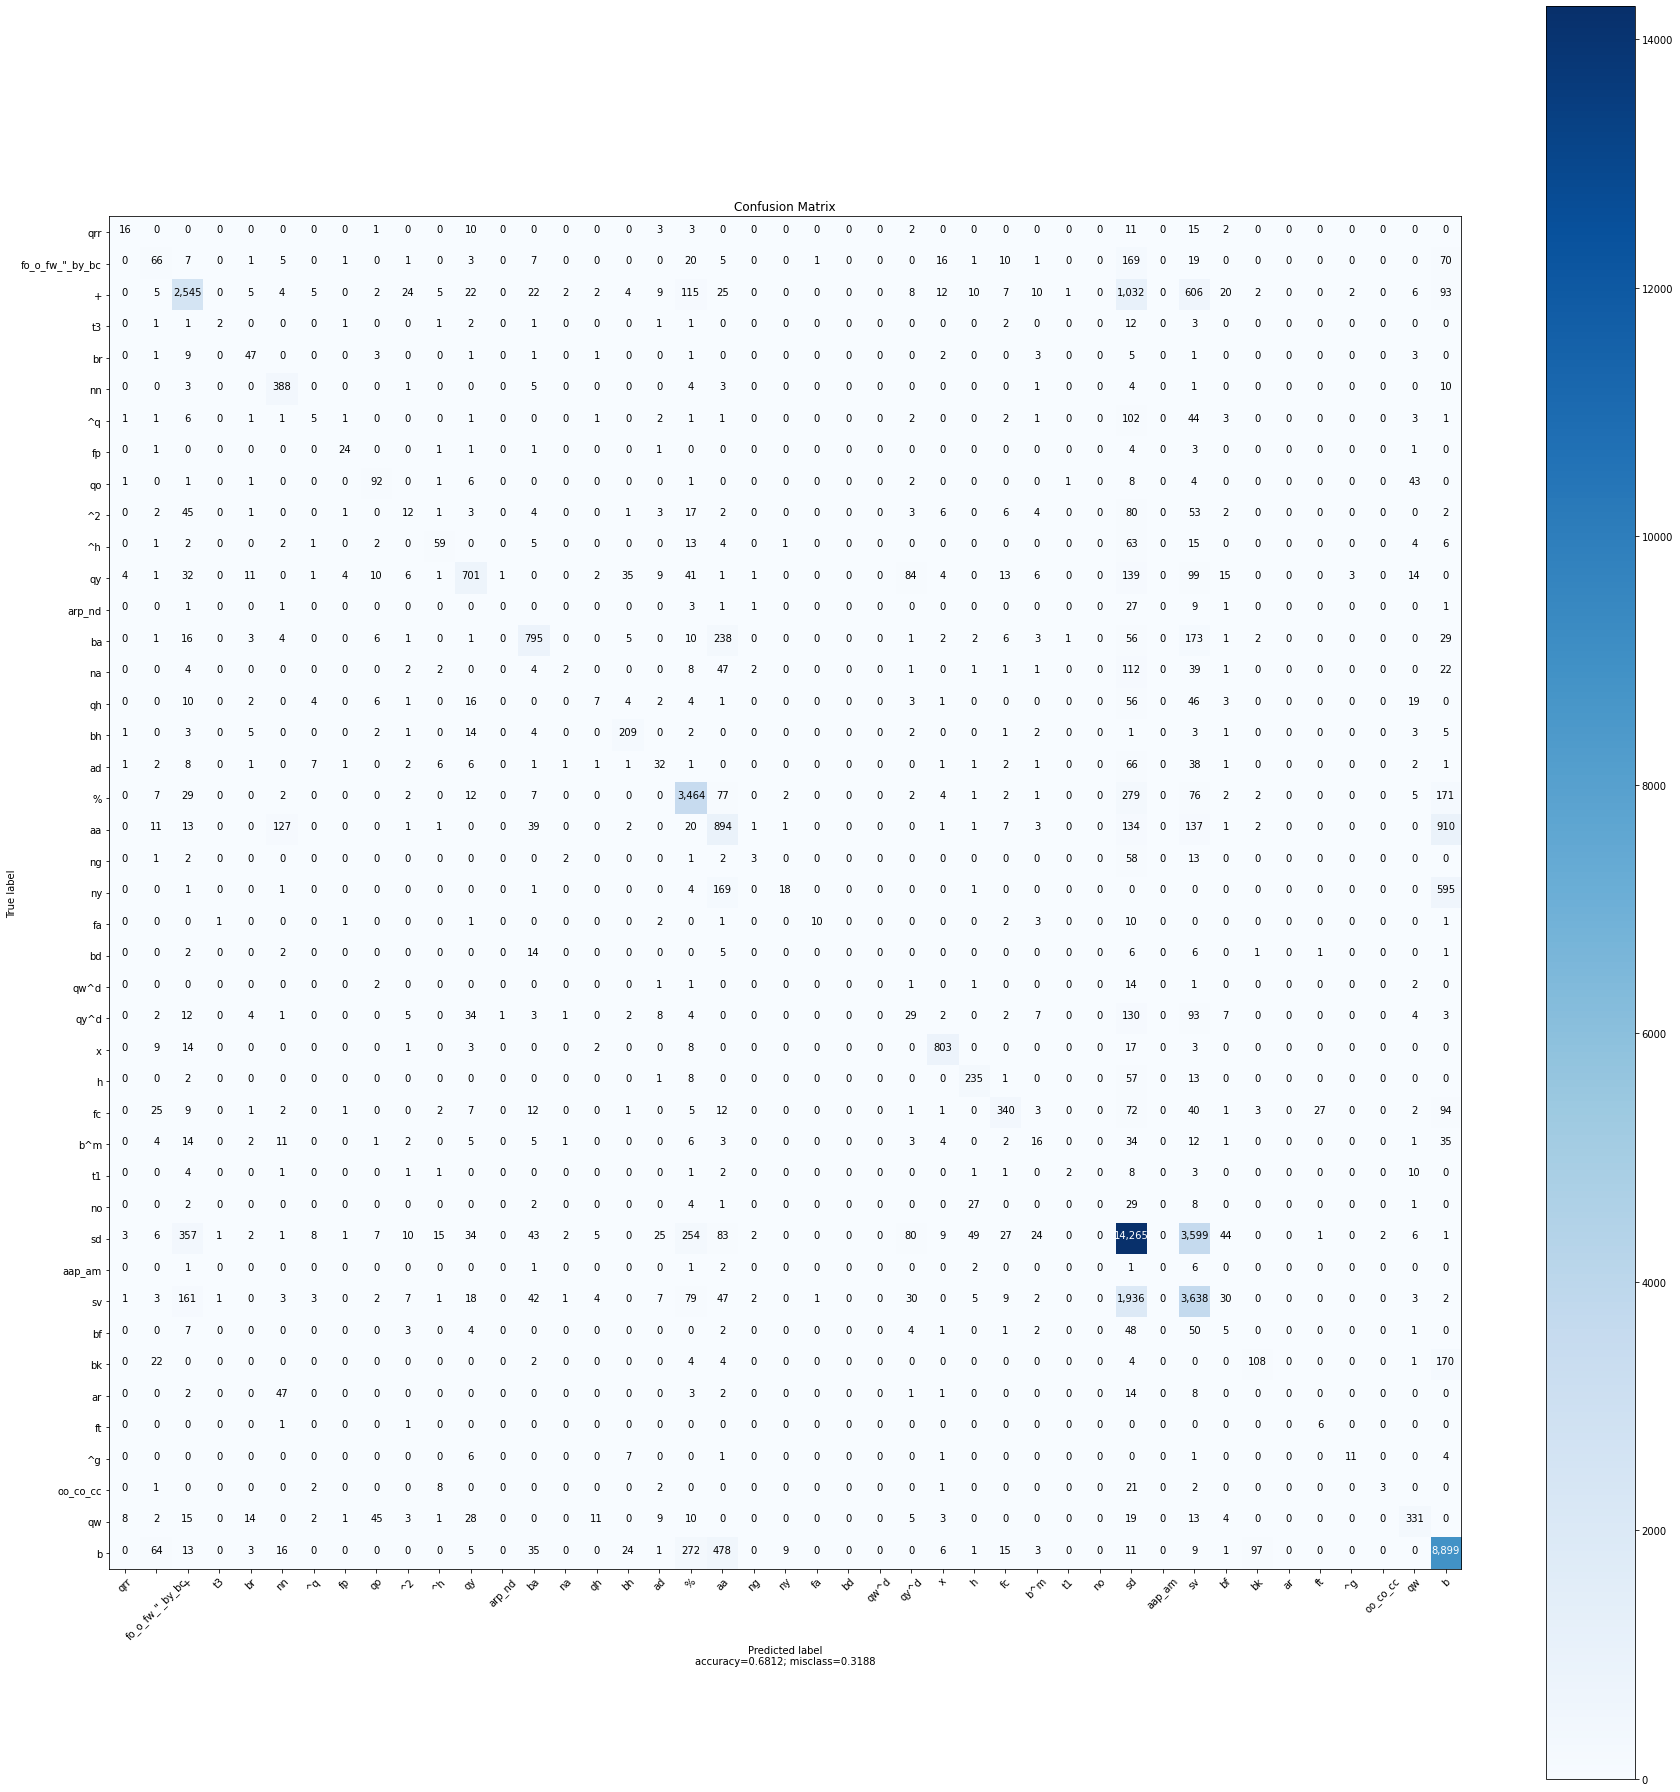

In [ ]:
# Build the confusion matrix off these predictions
test_predictions = model.predict(test_sentences_X, batch_size = 100)
rounded_labels_Gold = np.argmax(y_test, axis=1)
rounded_labels_pred = np.argmax(test_predictions, axis=1)

# print(rounded_labels,"\n",test_predictions)
cm=sklearn.metrics.confusion_matrix(rounded_labels_Gold,rounded_labels_pred)
plot_confusion_matrix(cm,normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")

In [ ]:
# Calculate Accuracies for "br" and "bf"
def Cal_Accuracy_Minority(class_name,ConfusionMatrix):
    # Finding position of class in confusion Matrix
    Position = np.argmax(one_hot_encoding_dic[class_name])
    print('Position:',Position)
    # Finding True positive
    TP_minority = ConfusionMatrix[Position][Position]
    # Total instances
    instances = 0 
    for i in range(len(ConfusionMatrix)):
        instances += ConfusionMatrix[Position][i]
    print('Instance :', instances)
    # Accuracy
    Accuracy_min = TP_minority/instances
    return Accuracy_min

# Calculate Accuracies for "br" and "bf" for imbalanced data
accuracy_br = Cal_Accuracy_Minority('br',cm)
accuracy_bf = Cal_Accuracy_Minority('bf',cm)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)


Position: 4
Instance : 78
Position: 35
Instance : 128
accuracy of br is : 0.6025641025641025
accuracy of bf is : 0.0390625


## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here. 




## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare. 

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class. 

In [ ]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


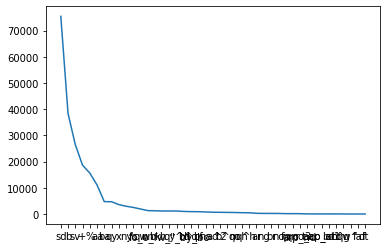

In [ ]:
# Plot the frequencies of the classes
plt.plot(value_counts)

<font color = "#909191"><b> As expected the Accuracy for br and bf which are minority classes is extremely low. There are not many samples for the model to be confident about classifying them.</b></br>
<b>Due to the reduced lack of training data for the minority classes, these minority classifiers will not be very confident in classification, as they have not been fully optimised. The frequent classifiers will be more optimised and will generate more confident scores for all examples, effectively crowding out the less confident minority classifiers. </b>
</font>

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [ ]:
# Re-built the model for the balanced training
model_balanced = Sequential(
    [
     Embedding(mask_zero = False, input_dim = VOCAB_SIZE + 1, output_dim = EMBED_SIZE, input_length = MAX_LENGTH, embeddings_initializer='glorot_uniform'),
     Bidirectional(LSTM(43, return_sequences = True)),
     Bidirectional(LSTM(43, return_sequences = False)),
     Dense(HIDDEN_SIZE),
     Activation('softmax')
    ]
)
model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_balanced.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 100)          4373300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 43)                3741      
                                                                 
 activation_2 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,297
Trainable params: 4,471,297
No

In [ ]:
# Train the balanced network - Seems to take long time to achieve good accuracy?
history = model_balanced.fit(train_input,
                    train_labels,
                    epochs=10,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    class_weight = d_class_weights,
                    verbose=1)

Epoch 1/10
547/547 [==============================] - 21s 38ms/step - loss: 1.9155 - accuracy: 0.3883 - val_loss: 1.9451 - val_accuracy: 0.4188
Epoch 2/10
547/547 [==============================] - 21s 38ms/step - loss: 1.6193 - accuracy: 0.4340 - val_loss: 2.1906 - val_accuracy: 0.3488
Epoch 3/10
547/547 [==============================] - 21s 38ms/step - loss: 1.4226 - accuracy: 0.4524 - val_loss: 1.9574 - val_accuracy: 0.4293
Epoch 4/10
547/547 [==============================] - 21s 38ms/step - loss: 1.2560 - accuracy: 0.4835 - val_loss: 1.9842 - val_accuracy: 0.4118
Epoch 5/10
547/547 [==============================] - 21s 38ms/step - loss: 1.1339 - accuracy: 0.5027 - val_loss: 1.8146 - val_accuracy: 0.4442
Epoch 6/10
547/547 [==============================] - 21s 38ms/step - loss: 1.0085 - accuracy: 0.5297 - val_loss: 1.9028 - val_accuracy: 0.4190
Epoch 7/10
547/547 [==============================] - 21s 38ms/step - loss: 0.9219 - accuracy: 0.5478 - val_loss: 1.7789 - val_accuracy:

<font color = "#909191"><b> The model is same as before. However, during training here we are assigning more weights to the minority classes to help in better predictions.</b></font>

## Test the model

In [ ]:
# Overall Accuracy
score = model_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 8s 14ms/step - loss: 1.8369 - accuracy: 0.4359


In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 43.59235763549805


Overall Accuracy: 43.59235763549805


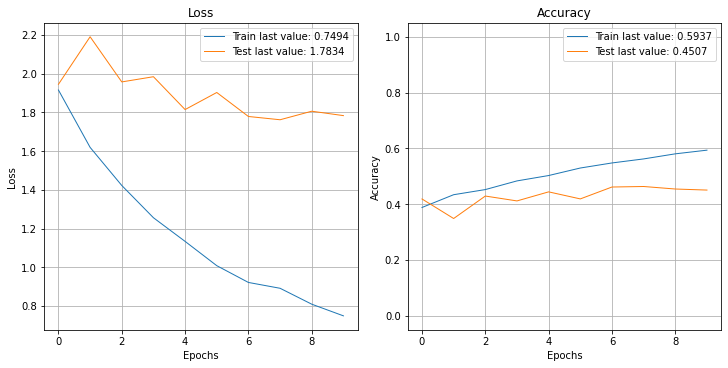

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

print("Overall Accuracy:", score[1]*100)
plot_history(history.history,path = "std.png")
plt.show()

In [ ]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

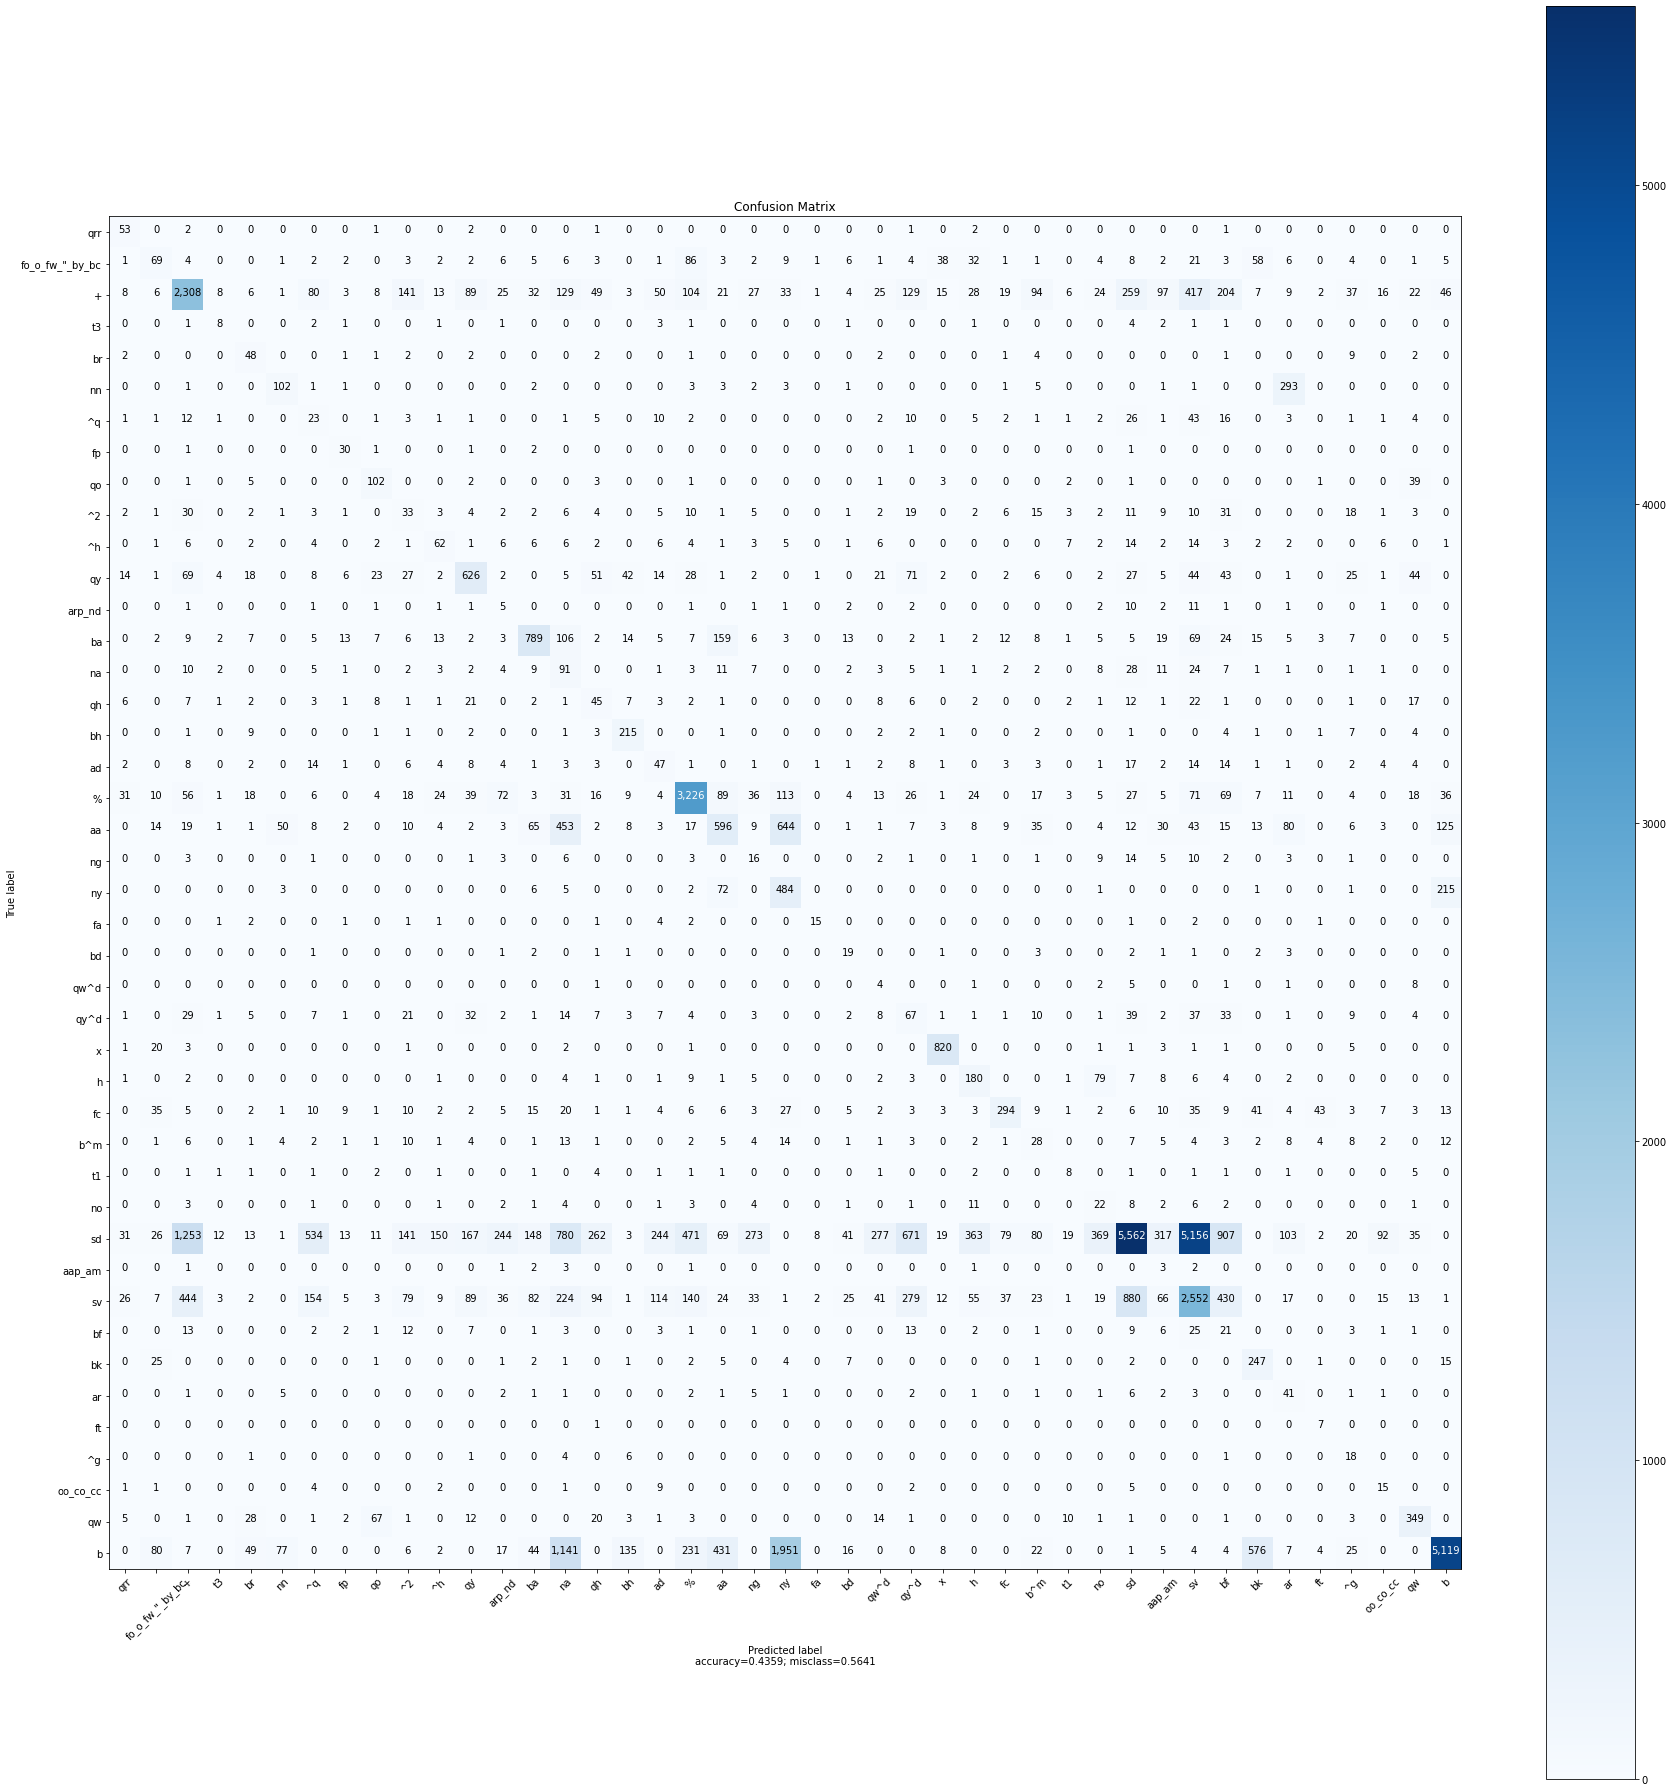

Position: 4
Instance : 78
Position: 35
Instance : 128
accuracy of br is : 0.6153846153846154
accuracy of bf is : 0.1640625


In [ ]:
# Build the confusion matrix off these predictions
matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
plot_confusion_matrix(matrix_balanced,normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")
# Calculate Accuracies for "br" and "bf"
accuracy_br = Cal_Accuracy_Minority('br',matrix_balanced)
accuracy_bf = Cal_Accuracy_Minority('bf',matrix_balanced)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)

<font color = "#909191"><b>Here we can see that the overall accuracy decreased considerably. However, the accuracy of minority classes 'br' and 'bf' went up.
</b></font>

### Accuracies
Accuracy for br is 50% while for bf is 8.5%.

### Explanation
Since we assigned more weights to the minority classes, the model was able to predict more properly for these classes.However, we observe that the overall model accuracy decreased significantly.

### Other ways to handle imbalanced classes
- Undersampling - Taking only a part of points from the majority classes

- Oversampling - Replicating some points from the minority class to increase its cardinality

- Generating synthetic data - Creating more data for the minority classes to increase their size manually.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance. 

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [ ]:
from keras.layers import Input, Reshape, Conv2D, BatchNormalization, MaxPool2D, concatenate, Flatten, TimeDistributed
from keras import Model
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = 150
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
concatenated_tensors = concatenate([maxpool_0, maxpool_1, maxpool_2])
# flatten concatenated tensors
flattened_tensors = TimeDistributed(Flatten())(concatenated_tensors)
# dense layer (dense_1)
dense_1 = Dense(EMBED_SIZE, activation='relu')(flattened_tensors)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

<font color = "#909191"><b>First we concatenated all the maxpool tensors. Then as the hint suggests, since the CNN layers want to interact with the LSTM layer, they have to be distributed across time. Hence, we use TimeDistributed Layer, pass a flattened layer to it and finally join it with the concatenated maxpool tensors. We then add a dense layer with Embedding size as parameter and relu as activation tensor and join it with the Flattened Time Distributed Tensor layer. Finally we add a dropout layer and join it with the previous Dense layer.</b></font>

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

In [ ]:
# BLSTM model

# Bidirectional 1
Bidirectional_1=Bidirectional(LSTM(EMBED_SIZE,return_sequences=True))(dropout_1)
# Bidirectional 2
Bidirectional_2=Bidirectional(LSTM(EMBED_SIZE,return_sequences=False))(Bidirectional_1)
# Dense layer (dense_2)
dense_2=Dense(EMBED_SIZE, activation='softmax')(Bidirectional_2)
flattened_layer = Flatten()(dropout_1)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)


<font color = "#909191"><b>First we created a Bidirectional LSTM layer with the same Embedding size defined before with return sequences as true and joined it with the previous dropout layer. We then create an additional Bidirectional LSTM layer with the same parameters as before except for return sequences which is set to False and join it with the previously created Bidirectional LSTM layer. Then we create a Dense layer with the embedding size and softmax activation function as parameter and join it with the second Bidirectional LSTM layer. We then flatten the dropout layer previously created and finally create an additional dropout layer and join it with the previous Dense layer.</b></font>

Concatenate 2 last layers and create the output layer
network

In [ ]:
# concatenate 2 final layers
a=concatenate([flattened_layer,dropout_2])
dense_layer = Dense(43, activation = 'softmax')(a)
# output
output = Model(inputs=inputs, outputs=dense_layer)
output.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
output.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 150, 100)     4373200     ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 150, 100, 1)  0           ['embedding_4[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)              (None, 148, 1, 64)   19264       ['reshape_1[0][0]']              
                                                                                              

<font color = "#909191"><b>Here we concatenate the flattened first dropout layer and the second dropout layer and then join it with a newly created Dense layer with 43 and softmax activation function as parameter which will be our final output layer.</b></font>

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [ ]:
# Train the model - use validation 

history = output.fit(train_input,
                     train_labels,
                     epochs=10,
                     batch_size=100,
                     validation_data=(val_input, val_labels),verbose=1)

Epoch 1/10
1400/1400 [==============================] - 45s 23ms/step - loss: 1.1086 - accuracy: 0.6700 - val_loss: 1.0074 - val_accuracy: 0.6908
Epoch 2/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.9556 - accuracy: 0.7125 - val_loss: 1.0919 - val_accuracy: 0.6918
Epoch 3/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.9220 - accuracy: 0.7248 - val_loss: 1.1193 - val_accuracy: 0.6967
Epoch 4/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.9038 - accuracy: 0.7314 - val_loss: 1.0701 - val_accuracy: 0.6894
Epoch 5/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.8834 - accuracy: 0.7415 - val_loss: 1.2086 - val_accuracy: 0.6851
Epoch 6/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.8746 - accuracy: 0.7461 - val_loss: 1.2125 - val_accuracy: 0.6799
Epoch 7/10
1400/1400 [==============================] - 32s 23ms/step - loss: 0.8569 - accuracy: 0.7536 - val_loss: 1.1810 -

560/560 [==============================] - 8s 14ms/step - loss: 1.3624 - accuracy: 0.6809
Overall Accuracy: 68.09237599372864


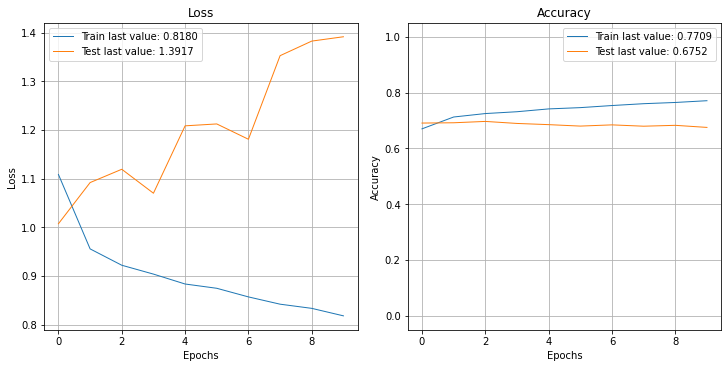

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

score = output.evaluate(test_sentences_X, y_test, batch_size=100)
print("Overall Accuracy:", score[1]*100)
plot_history(history.history,path = "std.png")
plt.show()

In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 68.09237599372864


In [ ]:
label_pred_cnn = output.predict(test_sentences_X, batch_size=100)


In [ ]:
index_pos_change = []
index_neg_change = []
for i in range(len(y_test)):
  true_label = y_test[i].argmax(axis=0)
  model1_pred = label_pred[i].argmax(axis=0)
  cnn_pred = label_pred_cnn[i].argmax(axis=0)
  if true_label == model1_pred and true_label != cnn_pred:
    index_neg_change.append(i)
  elif true_label != model1_pred and true_label == cnn_pred:
    index_pos_change.append(i)




<font color = "#909191"><b>Here we are comparing the changes that happened in the predictions of the first model and this model which has added context. If this model was able to predict something that the model 1 couldn't, we termed it as a positive change. If this model wasn't able to predict properly but the model 1 could, we termed it as a negative change. Finally in the below code block, we printed all such positive changes.</b></font>


In [ ]:

# creating a reverse mapping from word_ids to words
reverse_word_index = dict([(value, key) for (key, value) in wordvectors.items()])
# method to decode the sentence from a list of IDs to a string
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
# printing all the sentences which were missclassified by BiLSTM but correctly classified by CNN +  BiLSTM
for i, val in enumerate(index_pos_change):
  print(decode_sentence(X_test[val]))


Streaming output truncated to the last 5000 lines.
Right <laughter>. /
Right. /
Right.  /
{E I mean, } it's like nobody was concerned about it. /
# Huh.  # /
{D you know. }  {C And } now everybody is doing something about, which is good. /
# {D you # know? } /
Right <laughter>. /
I think,
{E I,
# Right. # /
# mean, } # it's,
Yeah.  /
#  (( Bro-, )) . #
# Oh.  # /
okay.  {F Oh, } # /
# {D yeah, }  cost ] efficient, yet.  /
I,
{C but } ] others, {D you know, } like tin cans and plastics,
[  They, +
Right. /
Right. /
heating and things,  (( getting ))  glass.  /
[ # I, + I ] noticed that a lot of gas stations are telling you to recycle your oil. /
{C And, } {E I mean, } that kind of surprises me <laughter>.  /
{F Um, } I don't know how cost efficient that would be, I guess, /
Yeah.  /
{C So, } it's one of those things that they really, - /
Yeah  /
Yeah,  /
Really. /
{C And } they said, {D Well, } we're not forced to do it yet,  /
# know. }  /
My parents are forced to do it  /
One that I c


### Minority Classes

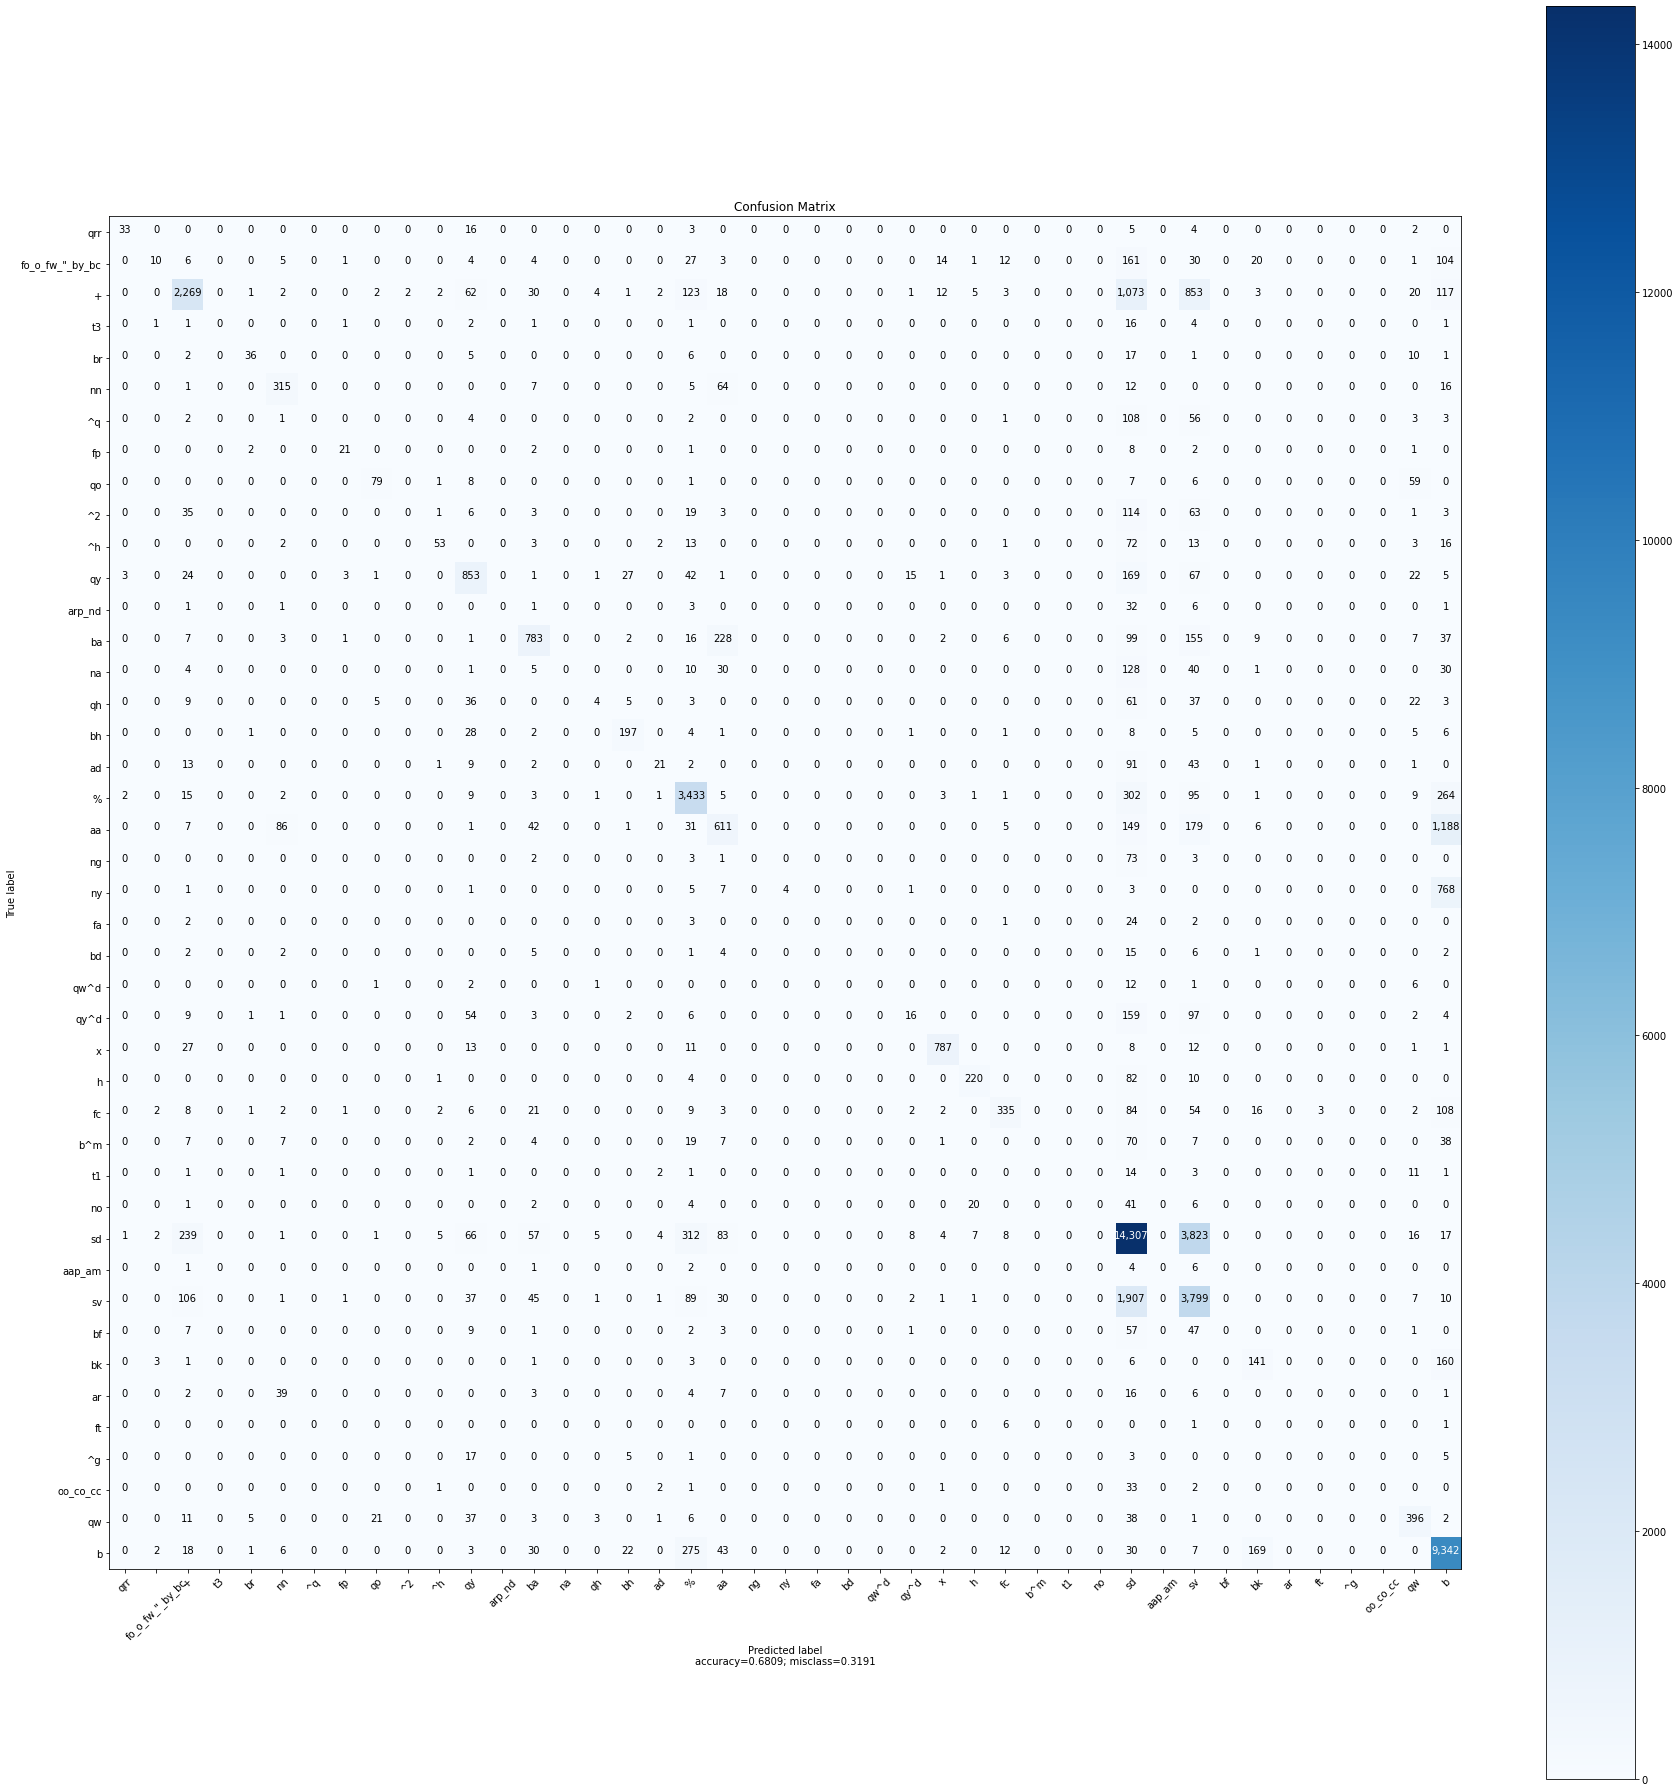

Position: 4
Instance : 78
Position: 35
Instance : 128
accuracy of br is : 0.46153846153846156
accuracy of bf is : 0.0


In [ ]:
# Build the confusion matrix off these predictions

matrix_cnn = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred_cnn.argmax(axis=1))
plot_confusion_matrix(matrix_cnn,normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")
# Calculate Accuracies for "br" and "bf"
accuracy_br = Cal_Accuracy_Minority('br',matrix_cnn)
accuracy_bf = Cal_Accuracy_Minority('bf',matrix_cnn)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)




<font color = "#909191"><b>If we compare model 1 which was a simple model and model 3 in which we added context we can see that it performed better in the accuracy of br. This shows that adding context did certainly help in better prediction of minority classes. In the above code block we can see the sentences which were incorrectly classified with no context but were correctly classified with context. We can also see that the model struggles with smaller sentences and that's where it makes most mistakes.</b></font>

<font color = "#909191"><b> Here the accuracy of the minority classes decreased again with bf being completely zero. This shows that bf is probably in even more minority than br. However, the overall accuracy of the model improved compared to both models.</b></font>